# SETUP INICIAL

In [1]:
import pandas as pd
from numpy import sqrt,mean,log,diff
import QuantLib as ql

from matplotlib import pyplot
import math

from datetime import datetime

## RODANDO MODELO COM S&P 500

In [80]:
#import data

df_options_spy = pd.read_csv('../draft/spy_yfinance_call_10_11.csv')
df_options_spy = df_options_spy.loc[df_options_spy['ano_vencimento'] > 0]
df_options_spy = df_options_spy.rename(columns={"expiry": "vencimento"})
df_options_spy['vencimento'] = pd.to_datetime(df_options_spy['vencimento'], format = '%Y/%m/%d')

df_options_spy = df_options_spy[(df_options_spy['preco'] > 1) & (df_options_spy['lastTradeDate'] > '2020-11-09') & (df_options_spy['ano_vencimento'] > 0.01)]
df_options_spy = df_options_spy.reset_index(drop=True)
print(len(df_options_spy))

1467


## Iniciando Heston

In [81]:
#configs

expiration_dates = [ql.Date(i.day, i.month, i.year) for i in df_options_spy['vencimento']]

strikes = list(df_options_spy['strike'])

premium = list(df_options_spy['preco'])

###6/10/2020 se for SPY
###16/09/2020 se for dados do ibov
###spot = 339.76 se for SPY, 94.48 se for ibov

####Novos:
###10/11/2020 se for SPY
###spot = 352.71 se for SPY

calculation_date = ql.Date(10, 11, 2020)

spot = 352.71

#theta, kappa, sigma, rho, v0
initial_condition=[0.02,0.2,0.5,-0.75,0.01]

day_count = ql.Actual365Fixed()

calendar = ql.UnitedStates()

ql.Settings.instance().evaluationDate = calculation_date

dividend_yield = ql.QuoteHandle(ql.SimpleQuote(0.0))
risk_free_rate = 0.01
dividend_rate = 0.0

yield_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count))


In [19]:
####Teste de precificação com o modelo de

theta, kappa, sigma, rho, v0 = initial_condition
payoff = ql.PlainVanillaPayoff(1, strikes[0])
exercise = ql.EuropeanExercise(expiration_dates[0])
european_option = ql.VanillaOption(payoff, exercise)
process = ql.HestonProcess(yield_ts, dividend_ts, 
                        ql.QuoteHandle(ql.SimpleQuote(spot)), 
                        v0, kappa, theta, sigma, rho)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)
european_option.setPricingEngine(engine)
european_option.NPV()

34.63930891383761

In [5]:
def heston_evaluate(chromo):
    theta = chromo[0]
    kappa = chromo[1]
    sigma = chromo[2]
    rho = chromo[3]
    v0 = chromo[4]

    lista_erro = []

    for i, j in enumerate(strikes):
        payoff = ql.PlainVanillaPayoff(1, j)
        exercise = ql.EuropeanExercise(expiration_dates[i])
        european_option = ql.VanillaOption(payoff, exercise)
        process = ql.HestonProcess(yield_ts, dividend_ts, 
                                ql.QuoteHandle(ql.SimpleQuote(spot)), 
                                v0, kappa, theta, sigma, rho)
        model = ql.HestonModel(process)
        engine = ql.AnalyticHestonEngine(model)
        european_option.setPricingEngine(engine)
         
        model_price = european_option.NPV()
        lista_erro.append(abs(premium[i] - model_price))

    diffs = sum(lista_erro)

    return diffs

In [12]:
x = model.params()
print(x)

[ 0.02; 0.2; 0.5; -0.75; 0.01 ]


In [8]:
import time
from scipy.optimize import differential_evolution

start = time.time()

#theta, kappa, sigma, rho, v0
bounds = ((0.001,1),(0.01,15), (0.01,1), (-1,1), (0.001,1))

sol = differential_evolution(
    heston_evaluate,  
    bounds, 
    workers=-1,
    disp=True,
    maxiter=100)

theta, kappa, sigma, rho, v0 = sol.x

print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % \
    (theta, kappa, sigma, rho, v0))

end = time.time()

print((end - start)/60)

differential_evolution step 1: f(x)= 4051.62
differential_evolution step 2: f(x)= 3479.52
differential_evolution step 3: f(x)= 3401.8
differential_evolution step 4: f(x)= 2626.68
differential_evolution step 5: f(x)= 2063.99
differential_evolution step 6: f(x)= 2001.81
differential_evolution step 7: f(x)= 2001.81
differential_evolution step 8: f(x)= 2001.81
differential_evolution step 9: f(x)= 1790.14
differential_evolution step 10: f(x)= 1505.07
differential_evolution step 11: f(x)= 1482.62
differential_evolution step 12: f(x)= 1482.62
differential_evolution step 13: f(x)= 1482.62
differential_evolution step 14: f(x)= 1482.62
differential_evolution step 15: f(x)= 1482.62
differential_evolution step 16: f(x)= 1482.62
differential_evolution step 17: f(x)= 1413.41
differential_evolution step 18: f(x)= 1413.41
differential_evolution step 19: f(x)= 1413.41
differential_evolution step 20: f(x)= 1413.41
differential_evolution step 21: f(x)= 1378.22
differential_evolution step 22: f(x)= 1378.2

In [9]:
#### Resultados do modelo na tabela

price_pred_list = []
optimized_parameters = sol.x

for i, row in df_options_spy.iterrows():
    payoff = ql.PlainVanillaPayoff(1, strikes[i])
    exercise = ql.EuropeanExercise(expiration_dates[i])
    european_option = ql.VanillaOption(payoff, exercise)
    process = ql.HestonProcess(yield_ts, dividend_ts, 
                            ql.QuoteHandle(ql.SimpleQuote(spot)), 
                            optimized_parameters[4], optimized_parameters[1], optimized_parameters[0], optimized_parameters[2], optimized_parameters[3]) #v0, kappa, theta, sigma, rho                 ####optimized_paramters = #theta, kappa, sigma, rho, v0
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model)
    european_option.setPricingEngine(engine)

    price_pred_list.append(european_option.NPV())


df_options_spy["pred_preco"] = price_pred_list
df_options_spy["erro"] = df_options_spy["preco"] - df_options_spy["pred_preco"]

##S&P: theta = 0.030547, kappa = 1.667948, sigma = 0.320508, rho = -0.838495, v0 = 0.064094

### Visualizações

In [76]:
###Tabela de quantidade de opções por tipo

def f(row):
    if row['spot'] > 1.01*row['strike']:
        val = 'OTM'
    elif row['spot'] > row['strike'] and row['spot'] < 1.01*row['strike']:
        val = 'ATM'
    else:
        val = 'ITM'
    return val

df_class = pd.DataFrame(df_options_spy.classificacao.value_counts())
df_class['Tipo da opção'] = df_class.index
print(df_class)

df_class.to_csv('quantidade_opcoes_spy.csv', index=False)

     classificacao Tipo da opção
ITM            948           ITM
OTM            472           OTM
ATM             47           ATM


In [77]:
###Tabela de quantidade de opções por moneyness

df_vencimento = pd.DataFrame(df_options_spy.ano_vencimento.value_counts())
df_vencimento['Vencimento (em anos)'] = df_vencimento.index
df_vencimento['Vencimento (em anos)'] = round(df_vencimento['Vencimento (em anos)'], 2)
df_vencimento = df_vencimento.rename(columns={'ano_vencimento': 'Quantidade'})
print(df_vencimento)
df_vencimento.to_csv('quantidade_opcoes_vencimento_spy.csv', index=False)

          Quantidade  Vencimento (em anos)
0.180556          99                  0.18
0.102778          94                  0.10
0.355556          84                  0.36
0.025000          81                  0.02
0.138889          78                  0.14
0.277778          72                  0.28
0.608333          62                  0.61
0.063889          55                  0.06
0.388889          54                  0.39
0.083333          51                  0.08
0.044444          51                  0.04
0.052778          50                  0.05
1.113889          45                  1.11
0.038889          43                  0.04
0.433333          41                  0.43
0.861111          41                  0.86
0.058333          41                  0.06
0.033333          38                  0.03
0.019444          37                  0.02
0.013889          37                  0.01
2.125000          37                  2.12
0.530556          35                  0.53
1.211111   

1.3937150300159413

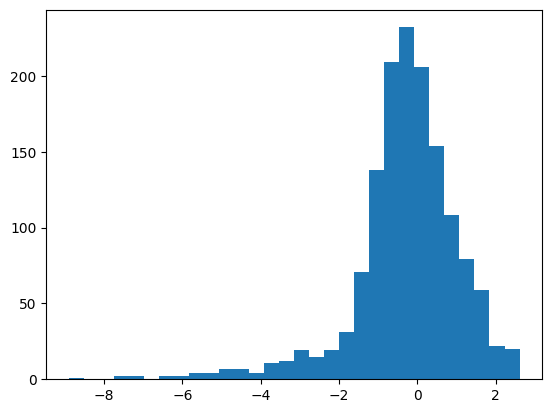

In [10]:
## Histograma de erros
pyplot.hist(df_options_spy["erro"], bins = 30)

erro_quadrado = df_options_spy["erro"]**2

erro_quadrado = math.sqrt(erro_quadrado.mean())
erro_quadrado

In [11]:
import statsmodels.api as sm

x = df_options_spy['pred_preco']
y = df_options_spy['preco']

model = sm.OLS(y, x).fit()
print(model.summary())

/home/aqrl-gabriel/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
                                 OLS Regression Results                                
Dep. Variable:                  preco   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.026e+06
Date:                Sat, 07 Nov 2020   Prob (F-statistic):                        0.00
Time:                        22:47:56   Log-Likelihood:                         -2398.2
No. Observations:                1440   AIC:                                      4798.
Df Residuals:                    1439   BIC:                                      4804.
Df Model:                           1                       

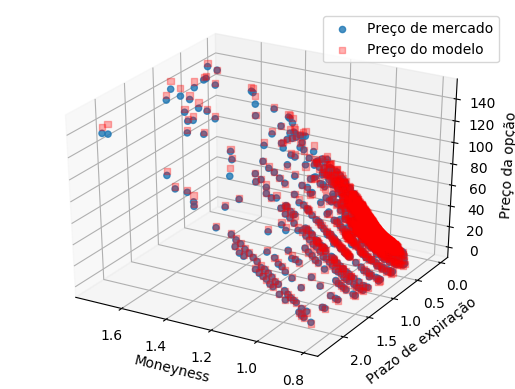

In [14]:
## Needed libs for visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm

###PLOT DOS PONTOS
fig = plt.figure()
plt.style.use('default')
fig.set_facecolor("w")
ax = plt.axes(projection='3d')
ax.scatter3D(df_options_spy["moneyness"], df_options_spy["ano_vencimento"], df_options_spy["preco"], label = "Preço de mercado", alpha = 0.8)
ax.scatter3D(df_options_spy["moneyness"], df_options_spy["ano_vencimento"], df_options_spy["pred_preco"], c = "red", label = 'Preço do modelo', alpha = 0.3, marker = "s")
ax.view_init(elev=30, azim=120) #azim=45
ax.set_xlabel('Moneyness')
ax.set_ylabel('Prazo de expiração')
ax.set_zlabel('Preço da opção')
ax.legend()


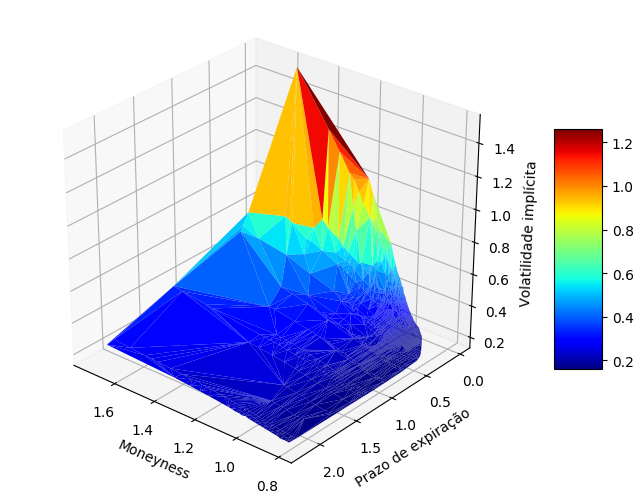

In [101]:
###PLOT DA SUPERFÍCIE DA VOLATILIDADE IMPLÍCITA
fig = plt.figure()
plt.style.use('default')
fig.set_facecolor("w")
ax = Axes3D(fig)
surf = ax.plot_trisurf(df_options_spy["moneyness"], df_options_spy["ano_vencimento"], df_options_spy["impliedVolatility"], cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness') 
ax.set_ylabel('Prazo de expiração')
ax.set_zlabel('Volatilidade implícita')
ax.view_init(elev=30., azim=130)
plt.show()

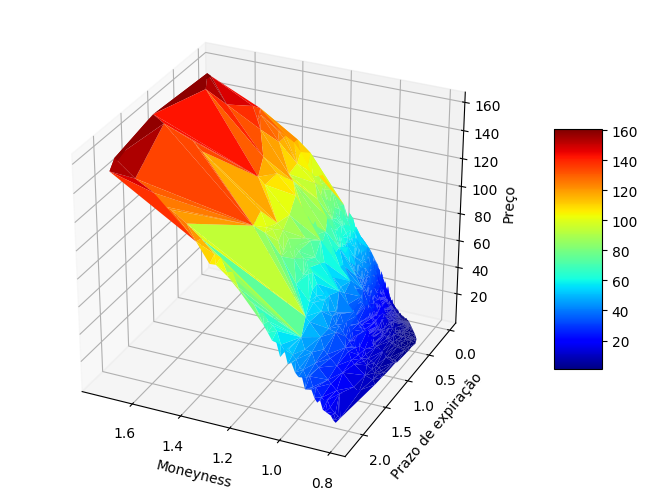

In [84]:
###PLOT DA SUPERFÍCIE DOS PREÇOS REAIS
fig = plt.figure()
plt.style.use('default')
fig.set_facecolor("w")
ax = Axes3D(fig)
surf = ax.plot_trisurf(df_options_spy["moneyness"], df_options_spy["ano_vencimento"], df_options_spy["preco"], cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Prazo de expiração')
ax.set_zlabel('Preço')
ax.view_init(elev=30., azim=115)
plt.show()

# PRECIFICACAO COM IBOV

### Dados ibov

In [20]:
df_options_bova = pd.read_excel("../data/opcoes_bova11_10_11.xlsx", header=0)

df_options_bova = df_options_bova.loc[df_options_bova['Mod.'] == 'E']
df_options_bova = df_options_bova.loc[df_options_bova['Tipo'] == 'PUT']  

df_options_bova = df_options_bova.rename(columns={
    "Vencimento": "vencimento",
    "Strike": 'strike',
    'Último': 'preco',
    'Vol. Impl. (%)': 'iv',
    'Data/Hora': 'data_ultima_venda',
    'A/I/OTM': 'classificacao',
    'Dias úteis': 'dias_vencimento'
    })

df_options_bova = df_options_bova[['vencimento', 'strike', 'preco', 'iv', 'data_ultima_venda', 'dias_vencimento', 'classificacao']]

df_options_bova['spot'] = 101

# iv_surface['strike'] = iv_surface['strike'].apply(lambda x: float(x.replace(",", ".")))
# iv_surface['iv'] = iv_surface['iv'].apply(lambda x: float(str(x).replace(",", ".")))
# iv_surface['preco'] = iv_surface['preco'].apply(lambda x: float(str(x).replace(",", ".")))
df_options_bova["moneyness"] = df_options_bova["spot"] / df_options_bova["strike"]
df_options_bova["ano_vencimento"] = df_options_bova["dias_vencimento"] / 360
df_options_bova = df_options_bova.dropna(subset = ['iv'])
df_options_bova['iv'] = df_options_bova['iv']/100

df_options_bova['vencimento'] = pd.to_datetime(df_options_bova['vencimento'], format = '%d/%m/%Y')

df_options_bova = df_options_bova[(df_options_bova['ano_vencimento'] > 0.01)]

print(len(df_options_bova))

65


In [21]:
# iv_surface = pd.read_csv("../data/opcoes_bova11.csv", sep=';')

# iv_surface['strike'] = iv_surface['strike'].apply(lambda x: float(x.replace(",", ".")))
# iv_surface['iv'] = iv_surface['iv'].apply(lambda x: float(str(x).replace(",", ".")))
# iv_surface['preco'] = iv_surface['preco'].apply(lambda x: float(str(x).replace(",", ".")))
# iv_surface["moneyness"] = iv_surface["spot"] / iv_surface["strike"]
# iv_surface["ano_vencimento"] = iv_surface["dias_vencimento"] / 360
# iv_surface = iv_surface.dropna(subset = ['iv'])
# iv_surface = iv_surface.loc[iv_surface['type'] == 'CALL']

# df_options = iv_surface
# df_options['vencimento'] = pd.to_datetime(df_options['vencimento'], format = '%d/%m/%Y')

# #df_options = df_options[(df_options['preco'] > 1)]

# print(len(df_options))


116


In [21]:
#configs

expiration_dates = [ql.Date(i.day, i.month, i.year) for i in df_options_bova['vencimento']]

strikes = list(df_options_bova['strike'])

premium = list(df_options_bova['preco'])

##antigo
###6/10/2020 se for SPY
###16/09/2020 se for dados do ibov
###spot = 339.76 se for SPY, 94.48 se for ibov

#####novo
###10/10/2020 se for dados do ibov
###101 se for ibov

calculation_date = ql.Date(10, 10, 2020)

spot = 101

#theta, kappa, sigma, rho, v0
initial_condition=[0.02,0.2,0.5,-0.75,0.01]

day_count = ql.Actual365Fixed()

calendar = ql.UnitedStates()

ql.Settings.instance().evaluationDate = calculation_date

dividend_yield = ql.QuoteHandle(ql.SimpleQuote(0.0))
risk_free_rate = 0.01
dividend_rate = 0.0

yield_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count))


In [22]:
def heston_evaluate(chromo):
    theta = chromo[0]
    kappa = chromo[1]
    sigma = chromo[2]
    rho = chromo[3]
    v0 = chromo[4]

    lista_erro = []

    for i, j in enumerate(strikes):
        payoff = ql.PlainVanillaPayoff(-1, j)  #### -1: put / 1:call
        exercise = ql.EuropeanExercise(expiration_dates[i])
        european_option = ql.VanillaOption(payoff, exercise)
        process = ql.HestonProcess(yield_ts, dividend_ts, 
                                ql.QuoteHandle(ql.SimpleQuote(spot)), 
                                v0, kappa, theta, sigma, rho)
        model = ql.HestonModel(process)
        engine = ql.AnalyticHestonEngine(model)
        european_option.setPricingEngine(engine)
         
        model_price = european_option.NPV()
        lista_erro.append((premium[i] - model_price)**2)

    diffs = sum(lista_erro)/len(lista_erro)

    return diffs

In [33]:
import time
from scipy.optimize import differential_evolution

start = time.time()

#theta, kappa, sigma, rho, v0
bounds = ((0.01,1),(0.01,15), (0.01,1), (-1,1), (0.01,1))

sol = differential_evolution(
    heston_evaluate,  
    bounds, 
    workers=-1,
    disp=True,
    maxiter=30)

theta, kappa, sigma, rho, v0 = sol.x

print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % \
    (theta, kappa, sigma, rho, v0))

end = time.time()

print((end - start)/60)

differential_evolution step 1: f(x)= 0.390514
differential_evolution step 2: f(x)= 0.390514
differential_evolution step 3: f(x)= 0.372892
differential_evolution step 4: f(x)= 0.278772
differential_evolution step 5: f(x)= 0.208082
differential_evolution step 6: f(x)= 0.144357
differential_evolution step 7: f(x)= 0.140846
differential_evolution step 8: f(x)= 0.140846
differential_evolution step 9: f(x)= 0.128927
differential_evolution step 10: f(x)= 0.128927
differential_evolution step 11: f(x)= 0.122421
differential_evolution step 12: f(x)= 0.122421
differential_evolution step 13: f(x)= 0.122421
differential_evolution step 14: f(x)= 0.122421
differential_evolution step 15: f(x)= 0.122421
differential_evolution step 16: f(x)= 0.122421
differential_evolution step 17: f(x)= 0.122421
differential_evolution step 18: f(x)= 0.122421
differential_evolution step 19: f(x)= 0.122421
differential_evolution step 20: f(x)= 0.122421
differential_evolution step 21: f(x)= 0.122421
differential_evolution

In [34]:
#### Resultados do modelo na tabela

price_pred_list = []
optimized_parameters = sol.x
df_options_bova = df_options_bova.reset_index(drop=True)

for i, row in df_options_bova.iterrows():
    payoff = ql.PlainVanillaPayoff(-1, strikes[i])
    exercise = ql.EuropeanExercise(expiration_dates[i])
    european_option = ql.VanillaOption(payoff, exercise)
    process = ql.HestonProcess(yield_ts, dividend_ts, 
                            ql.QuoteHandle(ql.SimpleQuote(spot)), 
                            optimized_parameters[4], optimized_parameters[1], optimized_parameters[0], optimized_parameters[2], optimized_parameters[3]) #v0, kappa, theta, sigma, rho                 ####optimized_paramters = #theta, kappa, sigma, rho, v0
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model)
    european_option.setPricingEngine(engine)

    price_pred_list.append(european_option.NPV())


df_options_bova["pred_preco"] = price_pred_list
df_options_bova["erro"] = df_options_bova["preco"] - df_options_bova["pred_preco"]

##IBOV: theta = 0.087035, kappa = 11.120810, sigma = 0.890333, rho = -0.310395, v0 = 0.153706

### Visualizações

In [35]:
###Tabela de quantidade de opções por tipo

df_class = pd.DataFrame(df_options_bova.classificacao.value_counts())
df_class['Tipo da opção'] = df_class.index
df_class = df_class.rename(columns={'classificacao': 'Quantidade'})
print(df_class)

df_class.to_csv('quantidade_opcoes_bova.csv', index=False)

     Quantidade Tipo da opção
OTM          51           OTM
ATM           7           ATM
ITM           7           ITM


In [36]:
###Tabela de quantidade de opções por moneyness

df_vencimento = pd.DataFrame(df_options_bova.ano_vencimento.value_counts())
df_vencimento['Vencimento (em anos)'] = df_vencimento.index
df_vencimento['Vencimento (em anos)'] = round(df_vencimento['Vencimento (em anos)'], 2)
df_vencimento = df_vencimento.rename(columns={'ano_vencimento': 'Quantidade'})
print(df_vencimento)
df_vencimento.to_csv('quantidade_opcoes_vencimento_bova.csv', index=False)

          Quantidade  Vencimento (em anos)
0.077778          36                  0.08
0.122222          21                  0.12
0.183333           5                  0.18
1.150000           1                  1.15
1.219444           1                  1.22
0.225000           1                  0.22


0.347443258988327

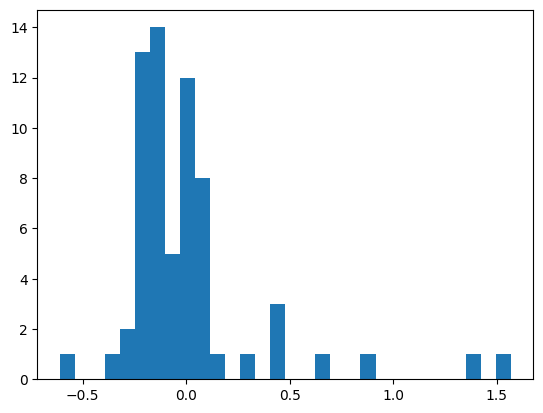

In [37]:
## Histograma de erros
pyplot.hist(df_options_bova["erro"], bins = 30)

erro_quadrado = df_options_bova["erro"]**2

erro_quadrado = math.sqrt(erro_quadrado.mean())
erro_quadrado

In [38]:
##Regressao

import statsmodels.api as sm

x = df_options_bova['pred_preco']
y = df_options_bova['preco']

model = sm.OLS(y, x).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  preco   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              9023.
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                    1.34e-70
Time:                        09:08:28   Log-Likelihood:                         -22.361
No. Observations:                  65   AIC:                                      46.72
Df Residuals:                      64   BIC:                                      48.90
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

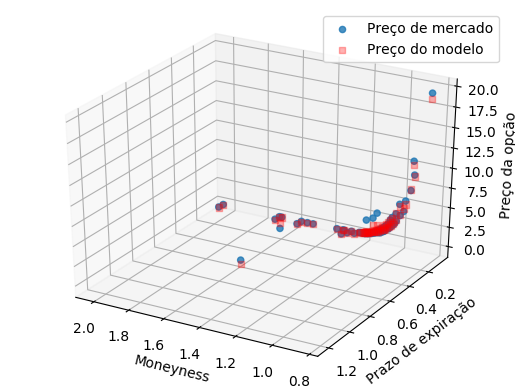

In [39]:
## Needed libs for visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm

###PLOT DOS PONTOS
fig = plt.figure()
plt.style.use('default')
fig.set_facecolor("w")
ax = plt.axes(projection='3d')
ax.scatter3D(df_options_bova["moneyness"], df_options_bova["ano_vencimento"], df_options_bova["preco"], label = "Preço de mercado", alpha = 0.8)
ax.scatter3D(df_options_bova["moneyness"], df_options_bova["ano_vencimento"], df_options_bova["pred_preco"], c = "red", label = 'Preço do modelo', alpha = 0.3, marker = "s")
ax.view_init(elev=30, azim=120) #azim=45
ax.set_xlabel('Moneyness')
ax.set_ylabel('Prazo de expiração')
ax.set_zlabel('Preço da opção')
ax.legend()

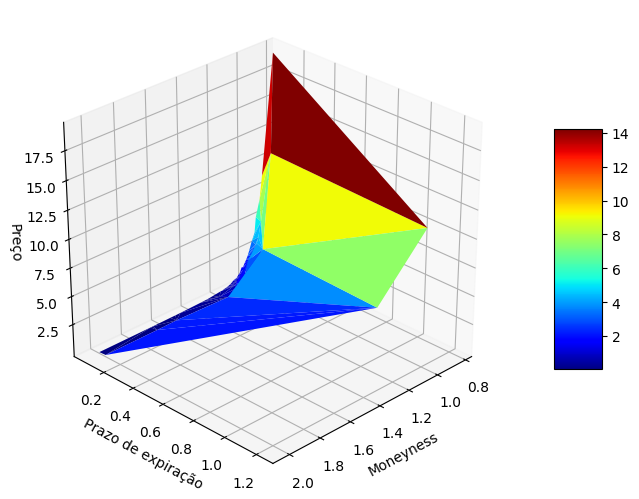

In [40]:
fig = plt.figure()
plt.style.use('default')
fig.set_facecolor("w")
ax = Axes3D(fig)
surf = ax.plot_trisurf(df_options_bova["moneyness"], df_options_bova["ano_vencimento"], df_options_bova["preco"], cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Prazo de expiração')
ax.set_zlabel('Preço')
ax.view_init(elev=30., azim=45)
plt.show()

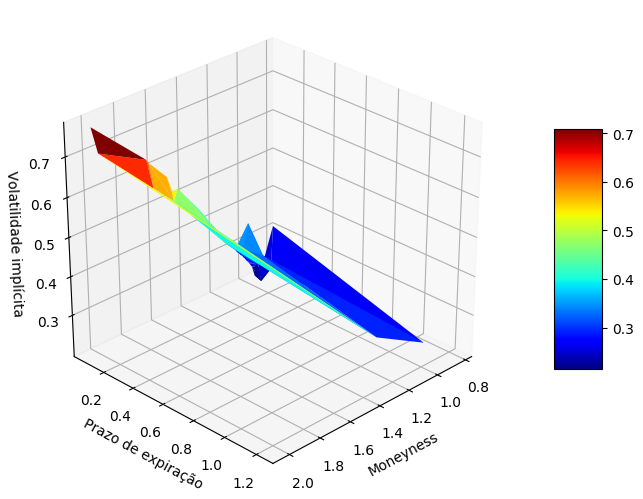

In [41]:
###PLOT DA SUPERFÍCIE DA VOLATILIDADE IMPLÍCITA
fig = plt.figure()
plt.style.use('default')
fig.set_facecolor("w")
ax = Axes3D(fig)
surf = ax.plot_trisurf(df_options_bova["moneyness"], df_options_bova["ano_vencimento"], df_options_bova["iv"], cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness') 
ax.set_ylabel('Prazo de expiração')
ax.set_zlabel('Volatilidade implícita')
ax.view_init(elev=30., azim=45)
plt.show()

## RODANDO COM QUANTLIB

In [ ]:
### Atenção: rodar algum setup antes (ibov ou s&p)

In [ ]:
# dummy parameters
initial_var = 0.01
rate_reversion = 0.5
long_term_var = 0.01
corr = -0.75
vol_of_vol = 0.1
# initial_var = 0.2; rate_reversion = 0.15; long_term_var = 0.6; corr = -0.75; vol_of_vol = 0.2;
process = ql.HestonProcess(flat_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(spot)),
                           initial_var, rate_reversion, long_term_var, vol_of_vol, corr)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)
heston_helpers = []
grid_data = []

In [ ]:
def setup_helpers(engine, expiration_dates, strikes, 
                  premium, ref_date, spot, yield_ts, 
                  dividend_ts):
    heston_helpers = []
    grid_data = []
    for j, s in enumerate(strikes):
        t = (expiration_dates[j] - calculation_date)
        p = ql.Period(t, ql.Days)
        sigma = premium[j]
        helper = ql.HestonModelHelper(p, calendar, spot, s,
                                    ql.QuoteHandle(ql.SimpleQuote(sigma)),
                                    yield_ts,
                                    dividend_ts)
        helper.setPricingEngine(engine)
        heston_helpers.append(helper)
        grid_data.append((expiration_dates[j], s))
    return heston_helpers, grid_data

In [ ]:
def setup_model(_yield_ts, _dividend_ts, _spot, initial_condition):
    theta, kappa, sigma, rho, v0 = initial_condition
    process = ql.HestonProcess(_yield_ts, _dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(_spot)), 
                           v0, kappa, theta, sigma, rho)
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model) 
    return model, engine

In [ ]:
##Rodar sempre antes de executar um otimizador

model, engine = setup_model(yield_ts, dividend_ts, spot, initial_condition)
heston_helpers, grid_data = setup_helpers(
    engine, expiration_dates, strikes, premium,
    calculation_date, spot, yield_ts, dividend_ts
)

In [ ]:
import numpy as np

def cost_function_generator(model, helpers, norm): # 
    def cost_function(params):
        params_ = ql.Array(list(params))
        model.setParams(params_)
        error = [h.calibrationError() for h in helpers]
        if norm:
            return np.sqrt(np.sum(np.abs(error)))
        else:
            return error
    return cost_function

In [24]:
### using model.calibrate

import time

start = time.time()

cost_function = cost_function_generator(
    model, heston_helpers, norm=True)

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
model.calibrate(heston_helpers, lm, ql.EndCriteria(1000, 600, 1.0e-8,1.0e-8, 1.0e-8))

theta, kappa, sigma, rho, v0 = model.params()

end = time.time()

print((end - start)/60)

print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % (theta, kappa, sigma, rho, v0))


1.142033080259959
theta = 0.263164, kappa = 4.012675, sigma = 0.000000, rho = -0.151935, v0 = 0.089369


In [ ]:
# date = expiration_dates

# for j, s in enumerate(strikes):
#     t = (date[j] - calculation_date)
#     p = ql.Period(t, ql.Days)
#     sigma = premium[j]
#     helper = ql.HestonModelHelper(p, calendar, spot, s,
#                                   ql.QuoteHandle(ql.SimpleQuote(sigma)),
#                                   yield_ts,
#                                   dividend_ts)
#     helper.setPricingEngine(engine)
#     heston_helpers.append(helper)
#     grid_data.append((date[j], s))

In [ ]:
import math

[i for i, value in enumerate(heston_helpers) if math.isinf(value.calibrationError()) or math.isnan(value.calibrationError())]

In [13]:
import time
from scipy.optimize import least_squares

#parameters sequence: initial_var, rate_reversion, long_term_var, vol_of_vol, corr

start = time.time()

cost_function = cost_function_generator(model, heston_helpers)

sol = least_squares(cost_function, initial_condition)

end = time.time()
print((end - start)/60)

theta, kappa, sigma, rho, v0 = model.params()

print("long_term_var = %f, rate_reversion = %f, vol_of_vol = %f, corr = %f, initial_var = %f" % (theta, kappa, sigma, rho, v0))

0.8062910676002503
long_term_var = -0.050293, rate_reversion = -0.729754, vol_of_vol = 0.000073, corr = -0.406958, initial_var = 3.583608


In [13]:
import time
from scipy.optimize import minimize
#parameters sequence: initial_var, rate_reversion, long_term_var, vol_of_vol, corr

start = time.time()

cost_function = cost_function_generator(
    model, heston_helpers, norm=True)

bounds = ((0,1),(0.01,15), (0.01,1), (-1,1), (0,1))

results = minimize(fun = cost_function, x0 = initial_condition, bounds = bounds, method = 'SLSQP', options={'disp': True,'maxiter': 1000})

theta, kappa, sigma, rho, v0 = results.x

end = time.time()
print((end - start)/60)

print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % (theta, kappa, sigma, rho, v0))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.296732185781897
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11
0.012475812435150146
theta = 1.000000, kappa = 0.010000, sigma = 0.010000, rho = -0.045262, v0 = 1.000000


In [16]:
## using scipy optimizer

import time
from scipy.optimize import differential_evolution

#parameters sequence: initial_var, rate_reversion, long_term_var, vol_of_vol, corr

start = time.time()

cost_function = cost_function_generator(model, heston_helpers)
result = differential_evolution(cost_function,
    workers = -1,
    disp = True,
    bounds = [(0,1), (0, 5), (0, 1), (0, 5), (-1, 1)],
    maxiter = 30)

optimized_parameters = result.x
#sol = least_squares(cost_function, initial_condition)
# theta, kappa, sigma, rho, v0 = model.params()

# print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % \
#     (theta, kappa, sigma, rho, v0))

end = time.time()

AttributeError: Can't pickle local object 'cost_function_generator.<locals>.cost_function'

In [26]:
print(cost_function)

<function cost_function_generator.<locals>.cost_function at 0x7fc8077bd0d0>
